In [17]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from PIL import Image

import numpy as np
import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

In [2]:
image_size = 64
channels = 3
batch_size = 16
learn_rate = 1e-4

In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# resnet
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# up-conv: we firstly upsample the image and go throught a conv net
def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"), # maginify twice
        nn.Conv2d(dim, default(dim_out, dim), kernel_size=3, padding=1),
    )

# why don't use max-pool?
def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        # batch_size * channels * (h * p1) * (w * p2) -> batch_size * (channels * p1 * p2) * (h // p1) * (w // p2) 
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), kernel_size=1),
    )

In [4]:
# (batch_size, ) -> (batch_size, dim) -> then add to each residual block
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim # the dim of the position embeddings

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings) # (dim // 2, )
        embeddings = time[:, None] * embeddings[None, :] # (batch_size, 1) * (1, dim // 2) -> (batch_size, dim // 2)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) # (batch_size, dim)
        return embeddings

In [5]:
# better conv_net
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False)) # unbiased way to calculate var
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    # (mlp ->) conv->group_norm->silu -> conv->group_norm->silu -> (conv)
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()

        # address time_embedding
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity() # mlp or identity

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1) # (b, c, 1, 1) -> (2, b, c // 2, 1, 1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False) # features to query, key, value (b, dim, h, w) -> (b, hidden_dim * 3, h, w)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [7]:
# normalize every channel
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [42]:
# input: noisy images of shape (b, c, h , w) and noise levels of shape (b, )
# output: noise added to the input of shape (b, c, h, w)
"""
1. conv(input_channels, init_dim)
2. resblock(init_dim, init_dim) -> resblock(init_dim, init_dim) -> groupnorm -> attention -> downsample
"""
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False, # self_attention
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [init_dim, init_dim * 1, init_dim * 2, inti_dim *4, ...]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [9]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

$$\text{noising:}\quad x_t\sim\mathcal{N}(x_t;\sqrt{\overline{\alpha_t}}x_0,(1-\overline{\alpha_t})\mathbf{I})$$

In [10]:
timesteps = 1000

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


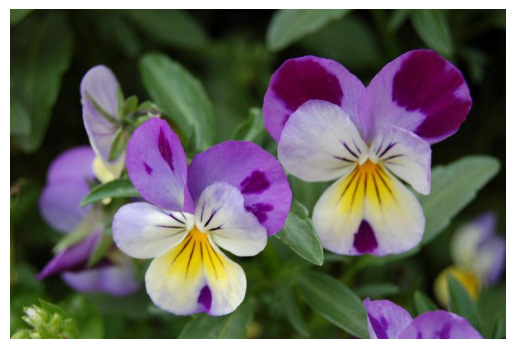

In [12]:
from datasets import load_dataset
dataset_name="huggan/flowers-102-categories" 
dataset = load_dataset(
        dataset_name,
        cache_dir= './data',
        split="train",
    )
plt.imshow(dataset['image'][0])
plt.axis('off')
plt.show()

In [18]:
# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Compose([
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

# define function
def _transforms(examples):
    images = [transform(image.convert("RGB")) for image in examples["image"]]
    return {"pixel_values": images}

transformed_dataset = dataset.with_transform(_transforms)

# create dataloader
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)

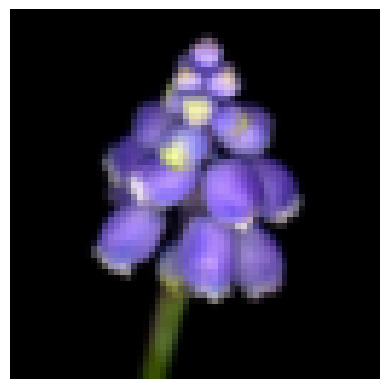

In [21]:
batch = next(iter(dataloader))
batch = batch['pixel_values']
x = reverse_transform(batch[0])
plt.imshow(x)
plt.axis('off')
plt.show()

In [23]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [24]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

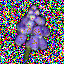

In [39]:
# take time step
t = torch.tensor([40])

get_noisy_image(batch[0], t)

In [40]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [43]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=learn_rate)

In [48]:
epochs = 50

for epoch in range(epochs):
  with tqdm(total=len(dataloader), desc=f'Epoch: {epoch + 1}/{epochs}', unit='batch') as pbar:
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      loss.backward()
      optimizer.step()
      pbar.update(1)
      pbar.set_postfix(loss=loss.item())
  samples = sample(model, image_size=image_size, batch_size=1, channels=channels)
  temp = reverse_transform(torch.tensor(samples[-1][0]))
  temp.save(f'./results/epoch_{epoch}.png')  

Epoch: 4/50:   9%|▊         | 44/512 [00:12<02:08,  3.64batch/s, loss=0.0215] 


KeyboardInterrupt: 

In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=1, channels=channels)

# show a random one
plt.imshow(reverse_transform(torch.tensor(samples[-1][0])))